# 03 - Richer set of features

In this notebook I add more features, including:
* AOV
* Time based features (Quarters)
* Customer Categorical
* Split some features by sales channel

What are the end results?
* With the default hyperparameters there is NO improvement in AUC when including more features
* I did slightly play with hyperparameters (but not included below) and there was a very modest improvement

Why wasn't there an improvement?
* RFM contain a tremendous amount of information already
* There aren't new sources of information (website interactions and email response are NOT included the data set)
* We do not have additional training records (that perhaps could help?)
* We have not tried more sophisticated algorithms

So - why continue?  In practice under a time & budget constraints the simple model is great to start using ... but as this is side project, so I will continue on.

What's next:
* This notebook is now unmanageable to include more exploration & experiments
* ptb_04 will be "cleanup" - that is, I'll take repeatable pieces and put them into modules


In [2]:

import sys
import polars as pl

sys.path.append('../pipeline')
from dataset import CSVDataset, KaggleDataset
from evaluate import Evaluator


In [44]:
# for name in list(globals().keys()):
#     if name not in ["__builtins__", "__name__", "__doc__"]:
#         del globals()[name]
# import gc
# gc.collect()

In [8]:
# kaggle_dataset = KaggleDataset()
# kaggle_dataset.load()

In [3]:
dataset = CSVDataset('../data/',["articles.csv","transactions_train.csv","customers.csv"])
dataset.load()


Loading ../data/articles.csv
Loading ../data/transactions_train.csv
Loading ../data/customers.csv



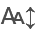

t_dat,customer_id,article_id,price,sales_channel_id
date,str,str,f64,i64
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…","""0663713001""",0.050831,2


In [10]:
query = '''
    SELECT *
    FROM transactions
    LIMIT 1
'''

swallow = dataset.run_query_display_results(query)


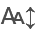

customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
str,f64,f64,str,str,i64,str
"""00000dbacae5abe5e23885899a1fa4…",null,null,"""ACTIVE""","""NONE""",49,"""52043ee2162cf5aa7ee79974281641…"
"""0000423b00ade91418cceaf3b26c6a…",null,null,"""ACTIVE""","""NONE""",25,"""2973abc54daa8a5f8ccfe9362140c6…"
"""000058a12d5b43e67d225668fa1f8d…",null,null,"""ACTIVE""","""NONE""",24,"""64f17e6a330a85798e4998f62d0930…"
"""00005ca1c9ed5f5146b52ac8639a40…",null,null,"""ACTIVE""","""NONE""",54,"""5d36574f52495e81f019b680c843c4…"
"""00006413d8573cd20ed7128e53b7b1…",1.0,1.0,"""ACTIVE""","""Regularly""",52,"""25fa5ddee9aac01b35208d01736e57…"
"""000064249685c11552da43ef22a503…",null,null,null,null,null,"""2c29ae653a9282cce4151bd87643c9…"
"""0000757967448a6cb83efb3ea7a3fb…",null,null,"""ACTIVE""","""NONE""",20,"""fe7b8e2b3fafb89ca90db17ffeeae0…"
"""00007d2de826758b65a93dd24ce629…",1.0,1.0,"""ACTIVE""","""Regularly""",32,"""8d6f45050876d059c830a0fe63f1a4…"
"""00007e8d4e54114b5b2a9b51586325…",null,null,"""ACTIVE""","""NONE""",20,"""2c29ae653a9282cce4151bd87643c9…"


In [58]:
query = '''
    select * from customers limit 10

'''

swallow = dataset.run_query_display_results(query)


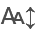

FN,Active,club_member_status,fashion_news_frequency,count(1)
f64,f64,str,str,i64
1.0,1.0,"""ACTIVE""","""Monthly""",735
0.0,0.0,"""PRE-CREATE""","""Empty""",2049
1.0,0.0,"""Empty""","""Regularly""",3
0.0,0.0,"""Empty""","""Regularly""",7
0.0,0.0,"""ACTIVE""","""Regularly""",2020
…,…,…,…,…
0.0,0.0,"""PRE-CREATE""","""Regularly""",79
1.0,1.0,"""LEFT CLUB""","""Regularly""",3
1.0,1.0,"""ACTIVE""","""None""",1


In [74]:
query = '''
    SELECT COALESCE(FN,0) as FN
        ,COALESCE(Active,0) as Active
        ,COALESCE(club_member_status,'Empty') as club_member_status
        ,COALESCE(fashion_news_frequency,'Empty') as fashion_news_frequency
        ,COUNT(1)
    FROM customers
    GROUP BY 1, 2, 3, 4
'''

swallow = dataset.run_query_display_results(query)

In [120]:
from datetime import date, timedelta

# Eventually I will be creating complex features so query will likely be generated
# and then there will be windows of responses and features as well
# I'm undecided at this point so I might simply put this in a class with three methods
# one to get features, one to get label, and one to get backtest

class QueryConstants:
    end_date=date(2020,9,22)
    feature_duration=365
    label_duration=30
    backtest_duration=30
    label_end =  end_date - timedelta(days=backtest_duration)
    feature_end = label_end - timedelta(days=label_duration)
    feature_start = feature_end - timedelta(days=feature_duration)

response_query = """
        SELECT
            t.customer_id,
            MAX(
                CASE
                    WHEN t.t_dat > DATE '{response_start}'  AND t.t_dat <= DATE '{response_end}'  THEN 1
                    ELSE 0
                END
            ) AS label
        FROM transactions t
        INNER JOIN customers c ON c.customer_id = t.customer_id
        GROUP BY t.customer_id
"""


feature_query = '''
SELECT *
    ,SQRT(t_count_quarter_1*t_count_quarter_2) as q1_x_q2
    ,SQRT(t_count_quarter_1*t_count_quarter_3) as q1_x_q3
    ,SQRT(t_count_quarter_1*t_count_quarter_4) as q1_x_q4
    ,SQRT(t_count_quarter_2*t_count_quarter_3) as q2_x_q3
    ,SQRT(t_count_quarter_2*t_count_quarter_4) as q2_x_q4
    ,SQRT(t_count_quarter_3*t_count_quarter_4) as q3_x_q4
    ,POWER(t_count_quarter_1*t_count_quarter_2*t_count_quarter_3*t_count_quarter_4,0.25) as q1_x_q2_x_q3_x_q4
FROM (
    SELECT
        t.customer_id

        ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*1) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(1 - 1)) DAY THEN 1 ELSE 0 END)
            as t_count_quarter_1
        ,COUNT(DISTINCT CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*1) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(1 - 1)) DAY THEN t.t_dat ELSE NULL END)
            as ti_count_quarter_1
        ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*1) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(1 - 1)) DAY THEN 590*price ELSE 0 END)
            as revenue_quarter_1


        ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*2) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(2 - 1)) DAY THEN 1 ELSE 0 END)
            as t_count_quarter_2
        ,COUNT(DISTINCT CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*2) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(2 - 1)) DAY THEN t.t_dat ELSE NULL END)
            as ti_count_quarter_2
        ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*2) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(2 - 1)) DAY THEN 590*price ELSE 0 END)
            as revenue_quarter_2


        ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*3) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(3 - 1)) DAY THEN 1 ELSE 0 END)
            as t_count_quarter_3
        ,COUNT(DISTINCT CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*3) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(3 - 1)) DAY THEN t.t_dat ELSE NULL END)
            as ti_count_quarter_3
        ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*3) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(3 - 1)) DAY THEN 590*price ELSE 0 END)
            as revenue_quarter_3


        ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*4) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(4 - 1)) DAY THEN 1 ELSE 0 END)
            as t_count_quarter_4
        ,COUNT(DISTINCT CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*4) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(4 - 1)) DAY THEN t.t_dat ELSE NULL END)
            as ti_count_quarter_4
        ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*4) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(4 - 1)) DAY THEN 590*price ELSE 0 END)
            as revenue_quarter_4


        ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (28*13) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (28*(13 - 1)) DAY THEN 1 ELSE 0 END)
            as t_count_month_13
        ,COUNT(DISTINCT CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (28*13) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (28*(13 - 1)) DAY THEN t.t_dat ELSE NULL END)
            as ti_count_month_13
        ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (28*13) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (28*(13 - 1)) DAY THEN 590*price ELSE 0 END)
            as revenue_month_13


        ,COUNT(1) total_transaction_items
        ,MAX(t.t_dat) - DATE '{feature_end}' as days_since_last
        --TODO: Perhaps make the channel data driven
        ,MAX(CASE WHEN sales_channel_id = 1 THEN t.t_dat ELSE DATE '{feature_start}' END) - DATE '{feature_end}' as days_since_last_channel_1
        ,MAX(CASE WHEN sales_channel_id = 2 THEN t.t_dat ELSE DATE '{feature_start}' END) - DATE '{feature_end}' as days_since_last_channel_2
        ,ROUND(590*SUM(price)) as total_revenue
        ,COUNT(DISTINCT t.t_dat) as total_transactions
        ,ROUND(ROUND(590*SUM(price))/COUNT(DISTINCT t.t_dat)) as aov
        ,SUM(CASE WHEN sales_channel_id = 1 THEN 1 ELSE 0 END) AS sales_channel_01
        ,SUM(CASE WHEN sales_channel_id = 2 THEN 1 ELSE 0  END) AS sales_channel_02
        ,MAX(CASE WHEN COALESCE(c.FN,0) = 1 THEN 1 ELSE 0 END) AS customer_fn
        ,MAX(CASE WHEN COALESCE(c.active,0) = 1 THEN 1 ELSE 0 END) AS customer_active
        ,MAX(CASE WHEN COALESCE(c.fashion_news_frequency, 'Empty') in ('Monthly','Reqularly') THEN 1 ELSE 0 END) AS customer_fashion_news_frequency

    FROM transactions t
    INNER JOIN customers c ON t.customer_id = c.customer_id
    WHERE t.t_dat <= DATE '{feature_end}' and t.t_dat > DATE '{feature_start}'
    --and customer_id = '00d40c65c316c02eac7fb0c628afbf57d616eed4b08f69ecfc115ca643a308af'
    GROUP BY t.customer_id
) x
'''

label_query = response_query.format(response_start=QueryConstants.feature_end, response_end=QueryConstants.label_end)
backtest_response_query = response_query.format(response_start=QueryConstants.label_end, response_end=QueryConstants.end_date)

arrow_table = dataset.duckdb_conn.execute(label_query).fetch_arrow_table()
label_df = pl.from_arrow(arrow_table)

arrow_table = dataset.duckdb_conn.execute(backtest_response_query).fetch_arrow_table()
backtest_response_df = pl.from_arrow(arrow_table)

query = feature_query.format(**vars(QueryConstants))
arrow_table = dataset.duckdb_conn.execute(query).fetch_arrow_table()
feature_df = pl.from_arrow(arrow_table)


display(feature_df)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

customer_id,t_count_quarter_1,ti_count_quarter_1,revenue_quarter_1,t_count_quarter_2,ti_count_quarter_2,revenue_quarter_2,t_count_quarter_3,ti_count_quarter_3,revenue_quarter_3,t_count_quarter_4,ti_count_quarter_4,revenue_quarter_4,t_count_month_13,ti_count_month_13,revenue_month_13,total_transaction_items,days_since_last,days_since_last_channel_1,days_since_last_channel_2,total_revenue,total_transactions,aov,sales_channel_01,sales_channel_02,customer_fn,customer_active,customer_fashion_news_frequency,q1_x_q2,q1_x_q3,q1_x_q4,q2_x_q3,q2_x_q4,q3_x_q4,q1_x_q2_x_q3_x_q4
str,"decimal[38,0]",i64,f64,"decimal[38,0]",i64,f64,"decimal[38,0]",i64,f64,"decimal[38,0]",i64,f64,"decimal[38,0]",i64,f64,i64,i64,i64,i64,f64,i64,f64,"decimal[38,0]","decimal[38,0]",i32,i32,i32,f64,f64,f64,f64,f64,f64,f64
"""0000757967448a6cb83efb3ea7a3fb…",0,0,0.0,0,0,0.0,0,0,0.0,2,1,27.98,0,0,0.0,2,-276,-365,-276,28.0,1,28.0,0,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""0000b2f1829e23b24feec422ef13df…",9,1,117.91,0,0,0.0,5,2,32.05,1,1,15.99,0,0,0.0,15,-31,-31,-365,166.0,4,42.0,15,0,1,1,0,0.0,6.708204,3.0,0.0,0.0,2.236068,0.0
"""0000c97821eb48d0e590fd309133f0…",5,2,26.95,1,1,12.99,0,0,0.0,4,1,44.96,0,0,0.0,10,-2,-64,-2,85.0,4,21.0,1,9,0,0,0,2.236068,0.0,4.472136,0.0,2.0,0.0,0.0
"""0000ffa57a8098a6cd99c0f0782b3e…",0,0,0.0,0,0,0.0,3,1,39.98,0,0,0.0,0,0,0.0,3,-239,-239,-365,40.0,1,40.0,3,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""00015c1a121e08bbd2552c15fbbb6e…",2,1,29.98,0,0,0.0,6,2,54.95,8,5,96.92,5,3,40.38,21,-78,-78,-365,222.0,11,20.0,21,0,0,0,0,0.0,3.464102,4.0,0.0,0.0,6.928203,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""fff94b7e15cd61eaf699f0e7d29e40…",7,1,102.93,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,7,-45,-365,-45,103.0,1,103.0,0,7,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""fff98edc27fc5d64c3027bf0e37025…",0,0,0.0,0,0,0.0,0,0,0.0,10,1,173.9,0,0,0.0,10,-309,-365,-309,174.0,1,174.0,0,10,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""fff9e830d0c21559ef730da1023cad…",0,0,0.0,0,0,0.0,0,0,0.0,2,1,49.98,0,0,0.0,2,-302,-302,-365,50.0,1,50.0,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=0.01, upper_percentile=99.99):
        """
        Initialize the Winsorizer with percentiles for lower and upper bounds.

        Args:
            lower_percentile (float): The lower percentile for winsorization (e.g., 5 for 5th percentile).
            upper_percentile (float): The upper percentile for winsorization (e.g., 95 for 95th percentile).
        """
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.bounds_ = None  # To store computed bounds during fitting

    def fit(self, X, y=None):
        """
        Compute the lower and upper bounds for each feature in the data.

        Args:
            X (array-like): The input data (2D array).
            y (ignored): Not used, for compatibility with Scikit-learn API.
        """
        X = np.asarray(X)
        # Add debugging to check the shape of the input
        if X.ndim != 2:
            raise ValueError(f"Expected 2D input, got {X.ndim}D input with shape {X.shape}")

        # Compute bounds
        self.bounds_ = {}
        for col in range(X.shape[1]):
            self.bounds_[col] = {
                "lower": np.percentile(X[:, col], self.lower_percentile),
                "upper": np.percentile(X[:, col], self.upper_percentile),
            }
        return self

    def transform(self, X):
        """
        Apply winsorization to the data using the computed bounds.

        Args:
            X (array-like): The input data (2D array).

        Returns:
            np.ndarray: The winsorized data.
        """
        if self.bounds_ is None:
            raise ValueError("Winsorizer has not been fitted yet.")

        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError(f"Expected 2D input, got {X.ndim}D input with shape {X.shape}")

        # Apply winsorization
        X_winsorized = X.copy()
        for col, bounds in self.bounds_.items():
            X_winsorized[:, col] = np.clip(X[:, col], bounds["lower"], bounds["upper"])
        return X_winsorized


In [121]:
# preprocessing
# 1. Split train/test

from sklearn.model_selection import train_test_split

aligned_df = feature_df.join(label_df, on="customer_id")
aligned_df  = aligned_df.sample(n=aligned_df.height, with_replacement=False)

display(aligned_df)

# Automatically separate features and labels
excluded_columns = ["customer_id", "label"]  # Columns to exclude
feature_columns = [col for col in aligned_df.columns if col not in excluded_columns]

# Split into features (X) and labels (y)
X = aligned_df.select(feature_columns).to_numpy()
y = aligned_df["label"].to_numpy()

# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

print(type(X_train))
#print(X_train.shape)






customer_id,t_count_quarter_1,ti_count_quarter_1,revenue_quarter_1,t_count_quarter_2,ti_count_quarter_2,revenue_quarter_2,t_count_quarter_3,ti_count_quarter_3,revenue_quarter_3,t_count_quarter_4,ti_count_quarter_4,revenue_quarter_4,t_count_month_13,ti_count_month_13,revenue_month_13,total_transaction_items,days_since_last,days_since_last_channel_1,days_since_last_channel_2,total_revenue,total_transactions,aov,sales_channel_01,sales_channel_02,customer_fn,customer_active,customer_fashion_news_frequency,q1_x_q2,q1_x_q3,q1_x_q4,q2_x_q3,q2_x_q4,q3_x_q4,q1_x_q2_x_q3_x_q4,label
str,"decimal[38,0]",i64,f64,"decimal[38,0]",i64,f64,"decimal[38,0]",i64,f64,"decimal[38,0]",i64,f64,"decimal[38,0]",i64,f64,i64,i64,i64,i64,f64,i64,f64,"decimal[38,0]","decimal[38,0]",i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,i32
"""936a85758288d68792bdc7eacdfb5e…",30,12,421.75,9,2,118.71,9,6,231.51,9,2,146.91,0,0,0.0,57,-1,-21,-1,919.0,22,42.0,7,50,0,0,0,16.431677,16.431677,16.431677,9.0,9.0,9.0,12.160801,1
"""93dec468591583d872b3a83ef2f9ac…",0,0,0.0,0,0,0.0,1,1,7.49,4,3,34.46,0,0,0.0,5,-219,-219,-365,42.0,4,11.0,5,0,1,1,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0
"""9448b947f3f37f4e99906f2548c24c…",4,2,54.96,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,4,-28,-365,-28,55.0,2,28.0,0,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"""947bce36a537cbf3060cb7f7cb2eb0…",0,0,0.0,10,1,303.9,3,2,68.97,1,1,39.99,0,0,0.0,14,-107,-169,-107,413.0,4,103.0,2,12,0,0,0,0.0,0.0,0.0,5.477226,3.162278,1.732051,0.0,0
"""9490fb9a2487b5129445be1f94cffb…",0,0,0.0,0,0,0.0,0,0,0.0,2,2,39.98,0,0,0.0,2,-294,-294,-365,40.0,2,20.0,2,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""90107bb1c562b0b8f0d619ee58e0e1…",2,1,7.98,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,2,-30,-30,-365,8.0,1,8.0,2,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
"""9374eda216203caeb69e7063089953…",6,1,46.74,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,6,-30,-365,-30,47.0,1,47.0,0,6,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
"""93bd8e72fadf6a7a29822e68fc687e…",1,1,9.99,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,1,-30,-365,-30,10.0,1,10.0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


<class 'numpy.ndarray'>


In [122]:
# Winsorize for extreme values

winsorizer = Winsorizer(lower_percentile=0.01, upper_percentile=99.99)

winsorizer.fit(X_train)

print(winsorizer.bounds_)
X_train_winsorized = winsorizer.transform(X_train)

print(sys.getsizeof(X_train))







{0: {'lower': 0.0, 'upper': 135.4301999999443}, 1: {'lower': 0.0, 'upper': 29.0}, 2: {'lower': 0.0, 'upper': 2375.5804279999347}, 3: {'lower': 0.0, 'upper': 116.0}, 4: {'lower': 0.0, 'upper': 22.0}, 5: {'lower': 0.0, 'upper': 2271.213049999845}, 6: {'lower': 0.0, 'upper': 105.0}, 7: {'lower': 0.0, 'upper': 22.0}, 8: {'lower': 0.0, 'upper': 1999.7896359993783}, 9: {'lower': 0.0, 'upper': 101.4301999999443}, 10: {'lower': 0.0, 'upper': 22.0}, 11: {'lower': 0.0, 'upper': 2263.340427999935}, 12: {'lower': 0.0, 'upper': 67.4301999999443}, 13: {'lower': 0.0, 'upper': 10.0}, 14: {'lower': 0.0, 'upper': 1042.467207999998}, 15: {'lower': 1.0, 'upper': 373.4301999999443}, 16: {'lower': -364.0, 'upper': 0.0}, 17: {'lower': -365.0, 'upper': 0.0}, 18: {'lower': -365.0, 'upper': 0.0}, 19: {'lower': 1.0, 'upper': 7152.732199999387}, 20: {'lower': 1.0, 'upper': 87.0}, 21: {'lower': 1.0, 'upper': 877.8603999998886}, 22: {'lower': 0.0, 'upper': 131.0}, 23: {'lower': 0.0, 'upper': 349.8603999998886}, 24:

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

standard_scaler.fit(X_train_winsorized)

X_train_standardized = standard_scaler.transform(X_train_winsorized)

print(standard_scaler.mean_)
print(standard_scaler.scale_)

[ 4.20574630e+00  1.16542527e+00  6.24237126e+01  3.22127382e+00
  8.54931529e-01  5.43808383e+01  3.18136184e+00  1.02537657e+00
  5.30970533e+01  3.18405157e+00  9.77880747e-01  6.07937990e+01
  1.27284810e+00  3.40864108e-01  1.74131243e+01  1.51304577e+01
 -1.10512229e+02 -2.43478226e+02 -1.65124618e+02  2.48925231e+02
  4.37942574e+00  5.69554178e+01  4.21455709e+00  1.09118138e+01
  3.67404728e-01  3.60611223e-01  3.80490437e-04  2.14503624e+00
  2.16991236e+00  2.08321612e+00  1.84681372e+00  1.81015869e+00
  1.99111234e+00  1.25547049e+00]
[7.69740877e+00 1.81082349e+00 1.22442217e+02 6.61703848e+00
 1.37921206e+00 1.19379650e+02 6.17432720e+00 1.58236162e+00
 1.10390644e+02 6.36836010e+00 1.56607657e+00 1.33397794e+02
 3.73465300e+00 7.58717861e-01 5.52158673e+01 2.18069252e+01
 1.01664976e+02 1.42807072e+02 1.31307674e+02 3.91795725e+02
 5.30931452e+00 5.11280590e+01 7.76239726e+00 1.95325823e+01
 4.82098013e-01 4.80177851e-01 1.95024528e-02 5.43405923e+00
 5.26135835e+00 5.1

In [130]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# smote = SMOTE(random_state=42)  # Initialize SMOTE
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_standardized, y_train)
#
# # Initialize RandomUnderSampler for under-sampling
# undersampler = RandomUnderSampler(random_state=42)
# X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_standardized, y_train)
#
#
# print(X_train_standardized.shape)
# print(X_train_balanced.shape)
# print(y_train_balanced.shape)

In [132]:
# training - cut and paste for now

import polars as pl

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# model = LogisticRegression()
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)


model.fit(X_train_standardized, y_train)

# # Compute AUC for training set
y_train_prob = model.predict_proba(X_train_standardized)[:, 1]  # Probabilities for the positive class
train_auc = roc_auc_score(y_train, y_train_prob)
#
print(train_auc)







0.7827005045387532


Computing optimal Threshold: 0.25
Computing predictions...
AUC: 0.78
Optimal Threshold: 0.25
Maximum F1 Score: 0.53
              precision    recall  f1-score   support

           0       0.89      0.76      0.82    690890
           1       0.44      0.66      0.53    194809

    accuracy                           0.74    885699
   macro avg       0.66      0.71      0.67    885699
weighted avg       0.79      0.74      0.76    885699



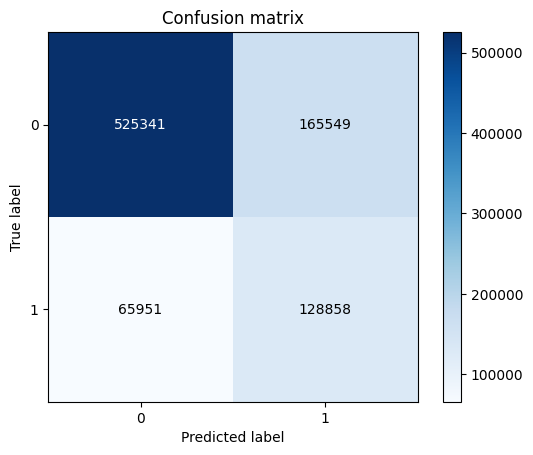

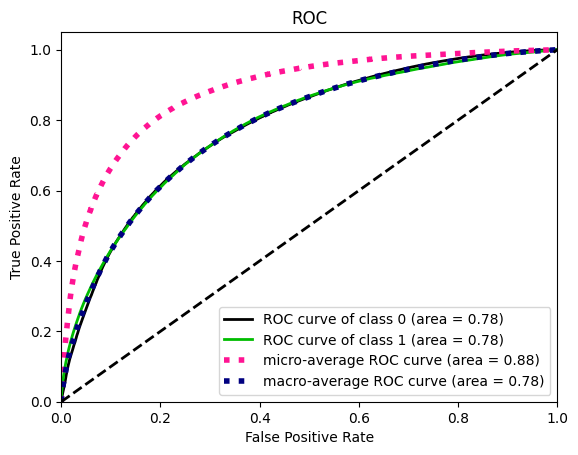

In [137]:
e_train = Evaluator(y_train, y_train_prob)
e_train.display_results()

In [138]:
# score the test

X_test_winsorized = winsorizer.transform(X_test)
X_test_standardized = standard_scaler.transform(X_test_winsorized)
y_test_prob_both = model.predict_proba(X_test_standardized)
y_test_prob = y_test_prob_both[:, 1]  # Probabilities for the positive class

Computing optimal Threshold: 0.27
Computing predictions...
AUC: 0.78
Optimal Threshold: 0.27
Maximum F1 Score: 0.53
              precision    recall  f1-score   support

           0       0.88      0.79      0.83     76766
           1       0.45      0.63      0.53     21645

    accuracy                           0.75     98411
   macro avg       0.67      0.71      0.68     98411
weighted avg       0.79      0.75      0.77     98411



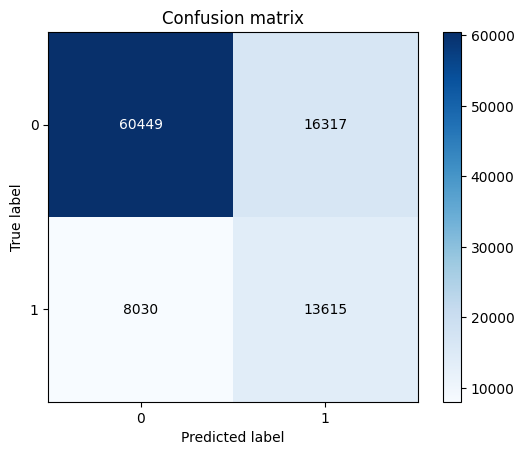

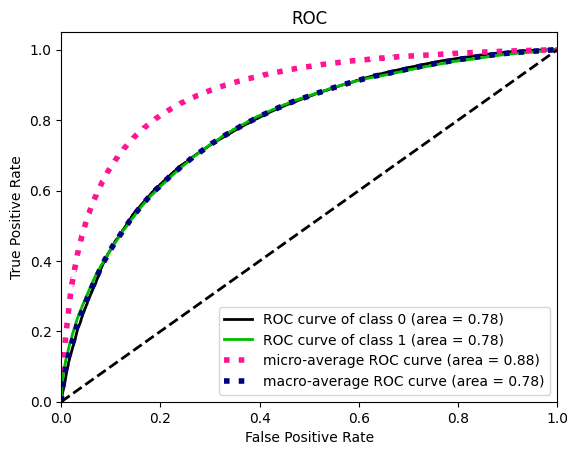

In [140]:
e_test = Evaluator(y_test, y_test_prob_both)
e_test.display_results()



In [141]:

end_date = date(2020,9,22)
feature_duration = 365
backtest_duration = 30
label_duration = 0
label_end =  end_date - timedelta(days=backtest_duration)
feature_end = label_end - timedelta(days=label_duration)
feature_start = feature_end - timedelta(days=feature_duration)


display("Initial feature_start: ", feature_start)
display("Initial feature_end: ", feature_end)
# print()

# this is nice ... I get features by just providing start and end
backtest_feature_query = feature_query.format(feature_end=feature_end, feature_start=feature_start)

# todo this is where dataset.run_query(query) would be good.  Returns DF.
arrow_table = dataset.duckdb_conn.execute(backtest_feature_query).fetch_arrow_table()
backtest_feature_df = pl.from_arrow(arrow_table)

# todo: I do not use this view
# dataset.duckdb_conn.register("backtest_features", backtest_feature_df)

print(backtest_feature_df.shape)

# I'm preparing to score records ... for scoring I think ...
# def score(model, feature_df, pk_column) and returns something reasonable .. meaning I want to return
# a dataframe with customer_id, probability (or all classes to generalize to multi-class)
# and maybe evaluation could have a different constructor that takes a DF instead?

features_without_id = backtest_feature_df.drop("customer_id")

print(features_without_id.shape)

features_without_id_winsorized = winsorizer.transform(features_without_id.to_numpy())
features_without_id_standard = standard_scaler.transform(features_without_id_winsorized)

scores_prob_positive = model.predict_proba(features_without_id_standard)[:, 1]
backtest_pred = [1 if prob >= e_test.optimal_threshold else 0 for prob in scores_prob_positive]

scores_df = pl.DataFrame({
    "customer_id": backtest_feature_df["customer_id"],
    "score": scores_prob_positive,
    "prediction": backtest_pred
})

dataset.duckdb_conn.register("scores", scores_df)

backtest_pred_truth_df = scores_df.join(backtest_response_df, on="customer_id")
backtest_response = np.array(backtest_pred_truth_df["label"])
backtest_score = np.array(backtest_pred_truth_df["score"])






'Initial feature_start: '

datetime.date(2019, 8, 24)

'Initial feature_end: '

datetime.date(2020, 8, 23)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(985282, 35)
(985282, 34)


Computing predictions...
AUC: 0.78
Optimal Threshold: 0.27
Maximum F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.88      0.78      0.83    772290
           1       0.44      0.62      0.52    212992

    accuracy                           0.75    985282
   macro avg       0.66      0.70      0.68    985282
weighted avg       0.79      0.75      0.76    985282



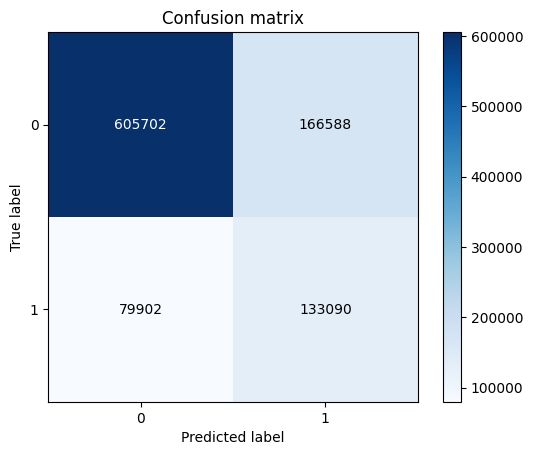

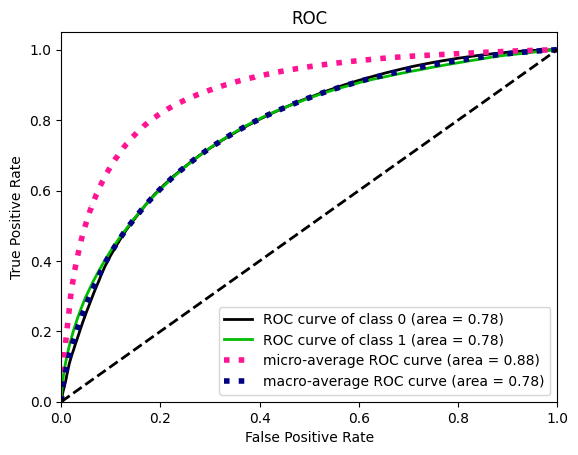

In [142]:
e_backtest = Evaluator(backtest_response, backtest_score, threshold=e_test.optimal_threshold)

e_backtest.display_results()


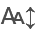

decile,buyer_count,scored_customer_count,non_buyer_count
i64,"decimal[38,0]",i64,"decimal[38,0]"
10,4071,98528,94457
9,6063,98528,92465
8,7023,98528,91505
7,9501,98528,89027
6,13091,98528,85437
5,17811,98528,80717
4,23464,98528,75064
3,30345,98528,68183
2,39654,98529,58875


In [143]:
# todo this is where I want to encapsulate the display of response curve ??? or do I care
# the display can be encapsulated ... but perhaps the computatiopn of DF still stays
# in notebook for now

query = f'''

SELECT decile, SUM(bought) buyer_count, COUNT(1) scored_customer_count, COUNT(1) - SUM(bought) non_buyer_count
FROM (
    SELECT s.customer_id, ntile(10) OVER (ORDER BY score desc) AS decile, COALESCE(bought,0) as bought
    from scores s
    left outer join (
        SELECT customer_id, COUNT(distinct t.customer_id) bought
        from transactions t
        WHERE t_dat > DATE '{feature_end}'
        GROUP BY customer_id
    ) t on t.customer_id = s.customer_id
    GROUP BY s.customer_id, score, bought
) x
GROUP BY decile
ORDER BY decile DESC
'''

backtest_results = dataset.run_query_display_results(query)
# backtest - use the new features and labels code I think firstly
# scoring ... leave this open for now

# I can use the feature query constant and set the correct parameters to get the backtest features

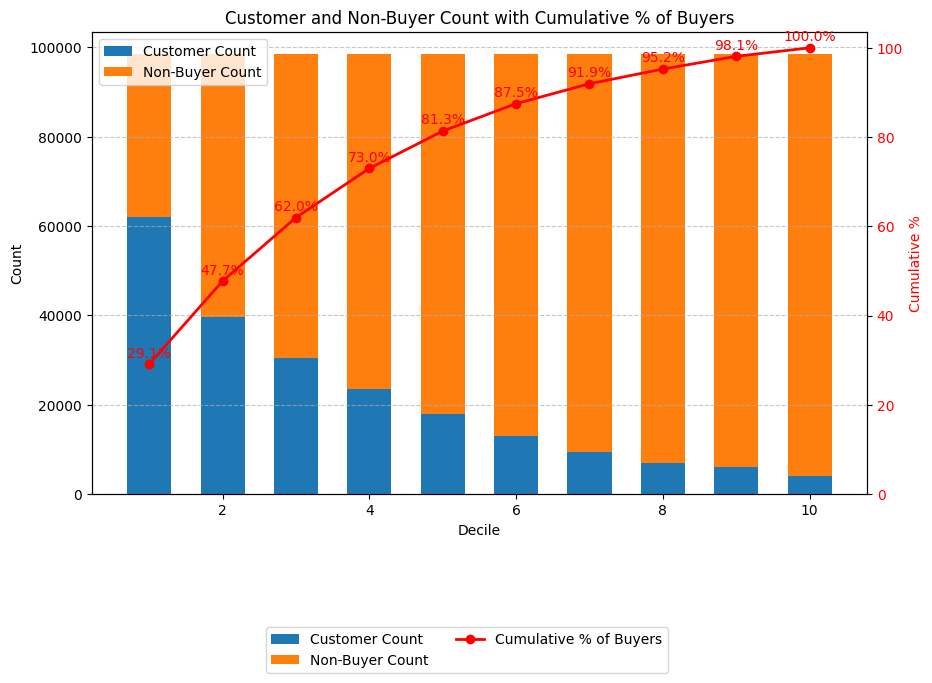

In [144]:


# plot the response curve ... put into a class
import matplotlib.pyplot as plt

# Assuming data is already created
data = backtest_results.to_pandas()

# Sort the DataFrame by decile in ascending order
data = data.sort_values(by="decile", ascending=True)

data["cumulative_percent"] = (data["buyer_count"].cumsum() / data["buyer_count"].sum() * 100)

# Extract columns as lists
decile = data["decile"].to_list()
customer_count = data["buyer_count"].to_list()
non_buyer_count = data["non_buyer_count"].to_list()
cumulative_percent = data["cumulative_percent"].to_list()

# print(cumulative_percent)
# print(customer_count)

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
ax1.bar(decile, customer_count, label="Customer Count", width=0.6)
ax1.bar(decile, non_buyer_count, bottom=customer_count, label="Non-Buyer Count", width=0.6)

# Label for the primary y-axis
ax1.set_xlabel('Decile')
ax1.set_ylabel('Count')
ax1.set_title('Customer and Non-Buyer Count with Cumulative % of Buyers')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc="upper left")

# Create a secondary y-axis for cumulative percent
ax2 = ax1.twinx()
ax2.plot(decile, cumulative_percent, color="red", marker="o", label="Cumulative % of Buyers", linewidth=2)
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for x, y in zip(decile, cumulative_percent):
    ax2.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color="red")

# Set the secondary y-axis to start at 0
ax2.set_ylim(0, ax2.get_ylim()[1])  # Start from 0, keep the max limit as it is


# Combine legends from both axes
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.show()

# this is not yet how I want it to look but will need to do for the time being

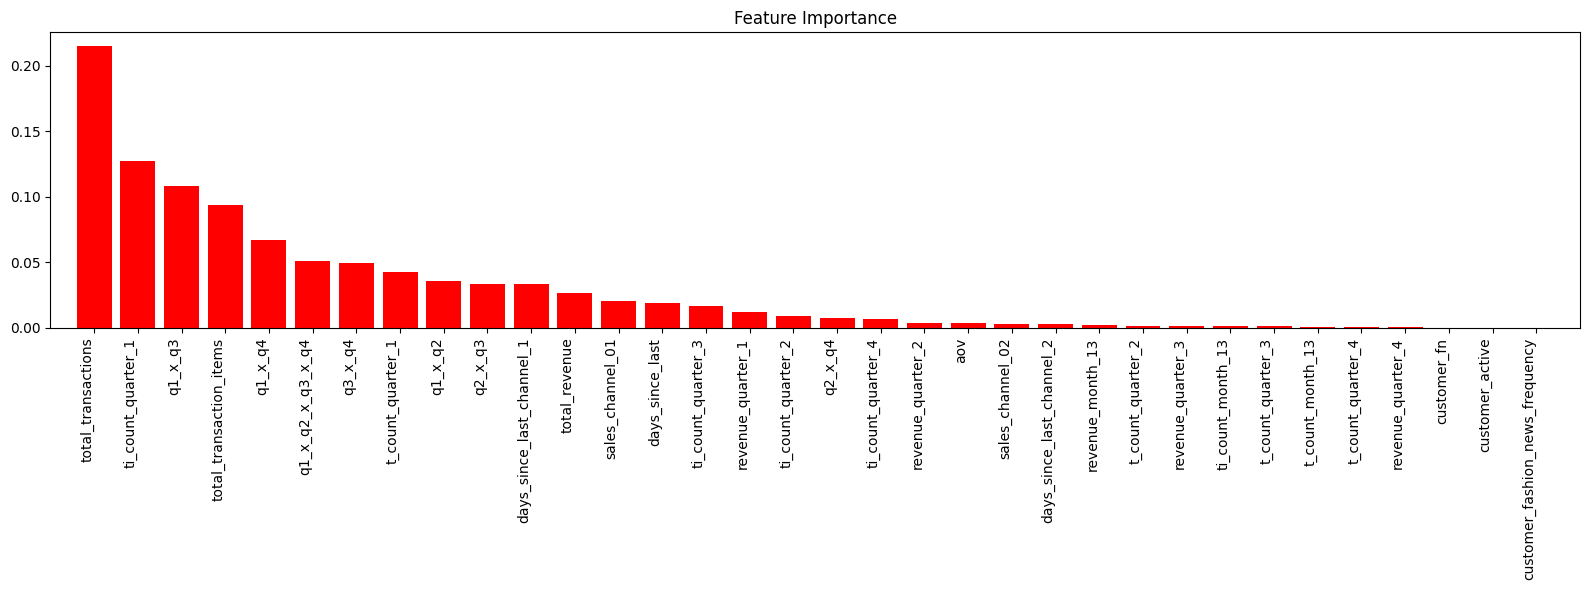

In [145]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Feature Importance
if isinstance(model, LogisticRegression):
    importance = model.coef_[0]
elif isinstance(model, RandomForestClassifier):
    importance = model.feature_importances_

indices = np.argsort(importance)[::-1]

# Create the plot with more space for labels
plt.figure(figsize=(16, 6))  # Adjust the width (12) and height (6) as needed
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importance[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [feature_columns[i] for i in indices], rotation=90, ha='right')  # Rotate labels
plt.xlim([-1, X.shape[1]])
plt.tight_layout()  # Automatically adjust subplot parameters to give space for labels
plt.show()